### Selecting columns, viualizing

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools
import torch
torch.use_deterministic_algorithms(True)

In [2]:
data = pd.read_csv("../dat/data_clean_new.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273543 entries, 0 to 273542
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tconst                       273543 non-null  object 
 1   titleType                    273543 non-null  object 
 2   primaryTitle                 273543 non-null  object 
 3   originalTitle                273543 non-null  object 
 4   isAdult                      273543 non-null  int64  
 5   startYear                    273543 non-null  object 
 6   endYear                      273543 non-null  object 
 7   runtimeMinutes               273543 non-null  object 
 8   genres                       273543 non-null  object 
 9   averageRating                273543 non-null  float64
 10  numVotes                     273543 non-null  int64  
 11  Budget                       49881 non-null   float64
 12  Gross US & Canada            18982 non-null   float64
 13 

In [4]:
data["Critic reviews"] = data["Critic reviews"].fillna(0)
data["User reviews"] = data["User reviews"].fillna(0)

data["isAdult2"] = data.apply(lambda row: int("Adult" in row["genres"]), axis=1)
print(len(data[data["isAdult"] != data["isAdult2"]]))  # We use the one based on the genres

# tconst was only required for joins
# titleType is only films for us, we filtered them
# we do not use the titles as predictors
# endYear is None for all films
# isAdult will be added back in a consistent format later on

# We drop writers and directors. These are interesting features,
# but having them as binary columns would be infeasible.
data = data.drop(columns=[
    "tconst", "titleType", "primaryTitle", "originalTitle", "endYear",
    "isAdult", "isAdult2", "Gross US & Canada", "Opening weekend US & Canada",
    "writers", "directors"])
data = data.dropna()

318


In [5]:
genre_list = data["genres"].unique().tolist()
for i, entry in enumerate(genre_list):
    genre_list[i] = entry.split(",")

genre_set = set(itertools.chain(*genre_list))
print(genre_set)

{'News', 'Action', 'Comedy', 'Drama', 'Western', 'Fantasy', 'Romance', 'Biography', 'Sci-Fi', 'Family', 'Animation', 'Film-Noir', 'Thriller', 'Crime', 'Adventure', 'War', 'Music', 'Documentary', 'History', 'Mystery', 'Musical', 'Horror', 'Sport'}


In [6]:
# News - History - Biography - Documentary --> Documentary
# Film-Noir - Crime --> Crime
# Western - Action --> Action
genre_set.difference_update(["News", "History", "Biography", "Film-Noir", "Western"])
transformation_dict = {
    "Documentary":  ["News", "History", "Biography", "Documentary"],
    "Crime": ["Film-Noir", "Crime"],
    "Action": ["Western", "Action"]
}
for genre in genre_set:
    print(genre, end=" ")
    if genre not in transformation_dict:
        transformation_dict[genre] = [genre]
    data[f"is{genre}"] = data.apply(lambda row: int(any(g in row["genres"] for g in transformation_dict[genre])), axis=1)

Action Comedy Drama Fantasy Romance Sci-Fi Family Animation Thriller Crime Adventure War Music Documentary Mystery Musical Horror Sport 

In [7]:
results = []
for genre in genre_set:
    results.append(data[f"is{genre}"].sum())

sum_results = sum(results)
for genre in genre_set:
    print(genre, data[f"is{genre}"].sum() / sum_results * 100, "% - ", data[f"is{genre}"].sum())

Action 9.843910219892901 % -  2592
Comedy 14.488625574417988 % -  3815
Drama 21.920929702631877 % -  5772
Fantasy 2.8179712126390943 % -  742
Romance 6.737305837226083 % -  1774
Sci-Fi 2.529338042611371 % -  666
Family 2.2938741407466483 % -  604
Animation 1.993847556112567 % -  525
Thriller 6.63096730090008 % -  1746
Crime 7.569025103490183 % -  1993
Adventure 6.7107212031445815 % -  1767
War 0.8658995100831719 % -  228
Music 1.7659792639854164 % -  465
Documentary 4.564961452280582 % -  1202
Mystery 3.4901826744141884 % -  919
Musical 0.5089058524173028 % -  134
Horror 4.348486574759789 % -  1145
Sport 0.9190687782461737 % -  242


In [8]:
# Genres are added as binary predictors, thus the genres column is no longer used.
data = data.drop(columns=["genres"])  # "isMusical", "isFilm-Noir", "isNews", "isSport", "genres"])

def unrated_to_not_rated(row):
    if row["Rating"] == "Unrated":
        return "Not Rated"
    else:
        return row["Rating"]

data["Rating"] = data.apply(unrated_to_not_rated, axis=1)

In [9]:
data[f"isRated"] = data.apply(lambda row: int(row["Rating"] != "Not Rated"), axis=1)

In [10]:
data = data.drop(columns=["Rating"])

In [11]:
def clean_unknowns(row, column):
    if row[column] == "\\N":
        return None
    else:
        return row[column]

def clean_reviews(row, column):
    if isinstance(row[column], str) and "K" in row[column]:
        if "." in row[column]:
            return int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100
        else:
            return int(row[column][:-1]) * 1000
    else:
        return row[column]

data["startYear"] = data.apply(lambda row: clean_unknowns(row, "startYear"), axis=1)
data["runtimeMinutes"] = data.apply(lambda row: clean_unknowns(row, "runtimeMinutes"), axis=1)
data["User reviews"] = data.apply(lambda row: clean_reviews(row, "User reviews"), axis=1)
data["Critic reviews"] = data.apply(lambda row: clean_reviews(row, "Critic reviews"), axis=1)

for column in ["startYear", "runtimeMinutes", "User reviews", "Critic reviews"]:
    data[column] = pd.to_numeric(data[column])



In [12]:
print("All features present:")
filtered = data.dropna()
print(len(filtered))

All features present:
10714


In [13]:
filtered.corr().style.background_gradient(cmap='coolwarm')

,startYear,runtimeMinutes,averageRating,numVotes,Budget,Gross worldwide,Critic reviews,User reviews,isAction,isComedy,isDrama,isFantasy,isRomance,isSci-Fi,isFamily,isAnimation,isThriller,isCrime,isAdventure,isWar,isMusic,isDocumentary,isMystery,isMusical,isHorror,isSport,isRated
startYear,1.000000,-0.035866,-0.201522,0.000240,-0.023247,-0.057779,0.193535,0.059286,0.062450,-0.029636,-0.023440,-0.007435,-0.072984,-0.021172,-0.006475,0.061377,0.037106,-0.043072,0.014030,-0.055095,-0.049175,0.076020,-0.012530,-0.079189,0.010315,-0.001944,-0.166430
runtimeMinutes,-0.035866,1.000000,0.327356,0.263119,0.281783,0.222601,0.197618,0.263035,0.157000,-0.198908,0.251510,-0.007126,0.037874,0.013944,-0.076188,-0.188850,-0.017890,0.034734,0.023855,0.098452,0.042845,0.132065,-0.004244,0.066672,-0.161497,0.023717,-0.059407
averageRating,-0.201522,0.327356,1.000000,0.373765,0.094344,0.207771,0.320645,0.259345,-0.088066,-0.116203,0.259717,-0.050636,0.017810,-0.039149,-0.063889,0.016830,-0.086492,0.033494,-0.027122,0.073410,0.039827,0.203175,-0.005072,0.017918,-0.194478,0.030757,0.009748
numVotes,0.000240,0.263119,0.373765,1.000000,0.484440,0.604826,0.632424,0.748153,0.143913,-0.058298,-0.053881,0.057248,-0.062362,0.161098,-0.019788,0.032153,0.008170,0.012083,0.174233,-0.003589,-0.039960,-0.039296,0.026221,-0.020421,-0.030451,-0.020418,0.181424
Budget,-0.023247,0.281783,0.094344,0.484440,1.000000,0.618972,0.470934,0.493993,0.288313,0.001382,-0.180196,0.122698,-0.074949,0.187617,0.073103,0.156256,-0.024849,-0.030025,0.412964,-0.018468,-0.046011,-0.066076,-0.035106,-0.002538,-0.114956,-0.014845,0.265037
Gross worldwide,-0.057779,0.222601,0.207771,0.604826,0.618972,1.000000,0.447165,0.528583,0.157823,0.004148,-0.143340,0.085165,-0.046415,0.120041,0.059786,0.150514,-0.022244,-0.057878,0.302571,-0.022194,-0.024488,-0.054449,-0.029502,-0.004438,-0.056392,-0.023446,0.165175
Critic reviews,0.193535,0.197618,0.320645,0.632424,0.470934,0.447165,1.000000,0.635358,0.153225,-0.093213,-0.038121,0.089842,-0.080864,0.187049,-0.051485,0.020177,0.045821,-0.004029,0.174983,-0.024894,-0.044073,-0.017815,0.084005,-0.023878,0.107734,-0.043205,0.252920
User reviews,0.059286,0.263035,0.259345,0.748153,0.493993,0.528583,0.635358,1.000000,0.168931,-0.102268,-0.054181,0.084869,-0.071699,0.187933,-0.031068,-0.015183,0.029438,-0.015094,0.178414,-0.005661,-0.027985,-0.051012,0.054678,-0.001391,0.052397,-0.031435,0.181563
isAction,0.062450,0.157000,-0.088066,0.143913,0.288313,0.157823,0.153225,0.168931,1.000000,-0.184316,-0.221293,0.011581,-0.210017,0.154244,-0.098392,-0.038377,0.085653,0.158979,0.268690,-0.021383,-0.114981,-0.112424,-0.113888,-0.057693,-0.092418,-0.043339,0.014920
isComedy,-0.029636,-0.198908,-0.116203,-0.058298,0.001382,0.004148,-0.093213,-0.102268,-0.184316,1.000000,-0.242004,-0.011676,0.150672,-0.116369,0.065015,0.103894,-0.286180,-0.096008,0.006730,-0.079938,0.023365,-0.198259,-0.174180,0.035580,-0.156284,-0.017278,0.076472


In [14]:
np.random.seed(42)
test_indices = np.random.choice(len(filtered), replace=False, size=int(len(filtered) / 10))


test_set = filtered.iloc[test_indices]
test_set, test_targets = test_set.drop("averageRating", axis=1).to_numpy(), test_set["averageRating"].to_numpy()
train_set = filtered.iloc[~test_indices]
train_set, train_targets = train_set.drop("averageRating", axis=1).to_numpy(), train_set["averageRating"].to_numpy()

In [15]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10714 entries, 1031 to 273540
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   startYear        10714 non-null  int64  
 1   runtimeMinutes   10714 non-null  float64
 2   averageRating    10714 non-null  float64
 3   numVotes         10714 non-null  int64  
 4   Budget           10714 non-null  float64
 5   Gross worldwide  10714 non-null  float64
 6   Critic reviews   10714 non-null  float64
 7   User reviews     10714 non-null  float64
 8   isAction         10714 non-null  int64  
 9   isComedy         10714 non-null  int64  
 10  isDrama          10714 non-null  int64  
 11  isFantasy        10714 non-null  int64  
 12  isRomance        10714 non-null  int64  
 13  isSci-Fi         10714 non-null  int64  
 14  isFamily         10714 non-null  int64  
 15  isAnimation      10714 non-null  int64  
 16  isThriller       10714 non-null  int64  
 17  isCrime 

### Logistic Regression, MAE

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

test_set = torch.from_numpy(test_set)
test_set_normalized = (test_set - test_set.mean(dim=0, keepdims=True)) / test_set.std(dim=0, keepdims=True)
test_set_normalized = torch.nan_to_num(test_set_normalized, nan=0)
test_targets = torch.from_numpy(test_targets)

train_set = torch.from_numpy(train_set)
train_set_normalized = (train_set - train_set.mean(dim=0, keepdims=True)) / train_set.std(dim=0, keepdims=True)
train_set_normalized = torch.nan_to_num(train_set_normalized, nan=0)
train_targets = torch.from_numpy(train_targets)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x)) * 9 + 1

In [17]:


# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

torch.manual_seed(1337)
model = Model()

opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
best_pred_lr = None


epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_lr = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0870], dtype=torch.float64)
Epoch 100, Training Loss (MAE) 1.2603, Validation Loss (MAE) 1.2956

tensor([0.0685], dtype=torch.float64)
Epoch 200, Training Loss (MAE) 1.0479, Validation Loss (MAE) 1.0805

tensor([0.0503], dtype=torch.float64)
Epoch 300, Training Loss (MAE) 0.8876, Validation Loss (MAE) 0.9153

tensor([0.0379], dtype=torch.float64)
Epoch 400, Training Loss (MAE) 0.7704, Validation Loss (MAE) 0.7964

tensor([0.0228], dtype=torch.float64)
Epoch 500, Training Loss (MAE) 0.6908, Validation Loss (MAE) 0.7189

tensor([0.0123], dtype=torch.float64)
Epoch 600, Training Loss (MAE) 0.6460, Validation Loss (MAE) 0.6740

tensor([0.0074], dtype=torch.float64)
Epoch 700, Training Loss (MAE) 0.6202, Validation Loss (MAE) 0.6477

tensor([0.0048], dtype=torch.float64)
Epoch 800, Training Loss (MAE) 0.6041, Validation Loss (MAE) 0.6317

tensor([0.0027], dtype=torch.float64)
Epoch 900, Training Loss (MAE) 0.5945, Validation Loss (MAE) 0.6217

tensor([0.0018], dtype=torch.float64)

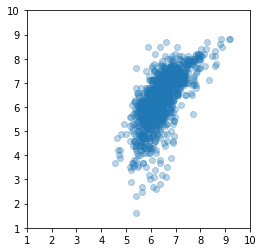

In [18]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Logistic Regression, MSE

In [19]:

loss_fn = nn.MSELoss()
val_loss_fn = nn.L1Loss()
torch.manual_seed(1337)


model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MSE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.2890], dtype=torch.float64)
Epoch 100, Training Loss (MSE) 1.0939, Validation Loss (MAE) 0.8783

tensor([0.0501], dtype=torch.float64)
Epoch 200, Training Loss (MSE) 0.7408, Validation Loss (MAE) 0.7003

tensor([0.0126], dtype=torch.float64)
Epoch 300, Training Loss (MSE) 0.6704, Validation Loss (MAE) 0.6485

tensor([0.0044], dtype=torch.float64)
Epoch 400, Training Loss (MSE) 0.6499, Validation Loss (MAE) 0.6300

tensor([0.0020], dtype=torch.float64)
Epoch 500, Training Loss (MSE) 0.6419, Validation Loss (MAE) 0.6219

tensor([0.0010], dtype=torch.float64)
Epoch 600, Training Loss (MSE) 0.6380, Validation Loss (MAE) 0.6181

tensor([0.0006], dtype=torch.float64)
Epoch 700, Training Loss (MSE) 0.6360, Validation Loss (MAE) 0.6162

tensor([0.0003], dtype=torch.float64)
Epoch 800, Training Loss (MSE) 0.6348, Validation Loss (MAE) 0.6151

tensor([0.0002], dtype=torch.float64)
Epoch 900, Training Loss (MSE) 0.6341, Validation Loss (MAE) 0.6144

tensor([0.0001], dtype=torch.float64)

### Logistic Regression, BCE

In [20]:

test_targets_bce = (test_targets - 1) / 9
train_targets_bce = (train_targets - 1) / 9

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x))

loss_fn = nn.BCELoss()
val_loss_fn = nn.L1Loss()

best_loss = np.inf

torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets_bce)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (BCE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0014], dtype=torch.float64)
Epoch 100, Training Loss (BCE) 0.7331, Validation Loss (MAE) 1.5187

tensor([0.0013], dtype=torch.float64)
Epoch 200, Training Loss (BCE) 0.7295, Validation Loss (MAE) 1.4888

tensor([0.0012], dtype=torch.float64)
Epoch 300, Training Loss (BCE) 0.7262, Validation Loss (MAE) 1.4599

tensor([0.0011], dtype=torch.float64)
Epoch 400, Training Loss (BCE) 0.7231, Validation Loss (MAE) 1.4316

tensor([0.0011], dtype=torch.float64)
Epoch 500, Training Loss (BCE) 0.7201, Validation Loss (MAE) 1.4045

tensor([0.0010], dtype=torch.float64)
Epoch 600, Training Loss (BCE) 0.7173, Validation Loss (MAE) 1.3781

tensor([0.0010], dtype=torch.float64)
Epoch 700, Training Loss (BCE) 0.7146, Validation Loss (MAE) 1.3524

tensor([0.0009], dtype=torch.float64)
Epoch 800, Training Loss (BCE) 0.7121, Validation Loss (MAE) 1.3277

tensor([0.0008], dtype=torch.float64)
Epoch 900, Training Loss (BCE) 0.7098, Validation Loss (MAE) 1.3038

tensor([0.0008], dtype=torch.float64)

### ReLU network #2, MAE

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1

model = Model()
list(model.modules())[1:]

[Linear(in_features=26, out_features=32, bias=True),
 Linear(in_features=32, out_features=1, bias=True)]

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1


loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])
best_loss = np.inf
# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.7923, Validation Loss (MAE) 0.8233

Epoch 200, Training Loss (MAE) 0.7245, Validation Loss (MAE) 0.7570

Epoch 300, Training Loss (MAE) 0.6831, Validation Loss (MAE) 0.7183

Epoch 400, Training Loss (MAE) 0.6539, Validation Loss (MAE) 0.6945

Epoch 500, Training Loss (MAE) 0.6319, Validation Loss (MAE) 0.6780

Epoch 600, Training Loss (MAE) 0.6137, Validation Loss (MAE) 0.6650

Epoch 700, Training Loss (MAE) 0.6011, Validation Loss (MAE) 0.6553

Epoch 800, Training Loss (MAE) 0.5934, Validation Loss (MAE) 0.6481

Epoch 900, Training Loss (MAE) 0.5872, Validation Loss (MAE) 0.6430

Epoch 1000, Training Loss (MAE) 0.5817, Validation Loss (MAE) 0.6393

Epoch 1100, Training Loss (MAE) 0.5771, Validation Loss (MAE) 0.6359

Epoch 1200, Training Loss (MAE) 0.5731, Validation Loss (MAE) 0.6328

Epoch 1300, Training Loss (MAE) 0.5694, Validation Loss (MAE) 0.6301

Epoch 1400, Training Loss (MAE) 0.5663, Validation Loss (MAE) 0.6276

Epoch 1500, Training Loss (MA

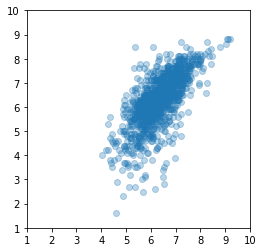

In [23]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### ReLU network #4, MAE

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
    
        return torch.sigmoid(self.layer4(x)) * 9 + 1


loss_fn = nn.L1Loss()
best_loss = np.inf


torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])

# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8336, Validation Loss (MAE) 0.8615

Epoch 200, Training Loss (MAE) 0.8221, Validation Loss (MAE) 0.8506

Epoch 300, Training Loss (MAE) 0.8150, Validation Loss (MAE) 0.8433

Epoch 400, Training Loss (MAE) 0.8070, Validation Loss (MAE) 0.8351

Epoch 500, Training Loss (MAE) 0.7982, Validation Loss (MAE) 0.8257

Epoch 600, Training Loss (MAE) 0.7876, Validation Loss (MAE) 0.8143

Epoch 700, Training Loss (MAE) 0.7752, Validation Loss (MAE) 0.8009

Epoch 800, Training Loss (MAE) 0.7612, Validation Loss (MAE) 0.7855

Epoch 900, Training Loss (MAE) 0.7450, Validation Loss (MAE) 0.7680

Epoch 1000, Training Loss (MAE) 0.7274, Validation Loss (MAE) 0.7503

Epoch 1100, Training Loss (MAE) 0.7087, Validation Loss (MAE) 0.7320

Epoch 1200, Training Loss (MAE) 0.6914, Validation Loss (MAE) 0.7142

Epoch 1300, Training Loss (MAE) 0.6757, Validation Loss (MAE) 0.6983

Epoch 1400, Training Loss (MAE) 0.6625, Validation Loss (MAE) 0.6855

Epoch 1500, Training Loss (MA

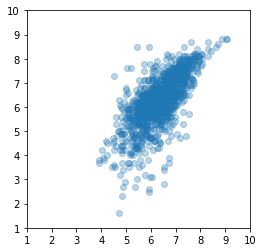

In [25]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

In [30]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer5 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer6 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
    
        return torch.sigmoid(self.layer6(x)) * 9 + 1

loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])
pred = None 
best_loss = np.inf


# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_relu = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8293, Validation Loss (MAE) 0.8566

Epoch 200, Training Loss (MAE) 0.8281, Validation Loss (MAE) 0.8553

Epoch 300, Training Loss (MAE) 0.8266, Validation Loss (MAE) 0.8538

Epoch 400, Training Loss (MAE) 0.8239, Validation Loss (MAE) 0.8510

Epoch 500, Training Loss (MAE) 0.8212, Validation Loss (MAE) 0.8482

Epoch 600, Training Loss (MAE) 0.8173, Validation Loss (MAE) 0.8443

Epoch 700, Training Loss (MAE) 0.8112, Validation Loss (MAE) 0.8379

Epoch 800, Training Loss (MAE) 0.8007, Validation Loss (MAE) 0.8266

Epoch 900, Training Loss (MAE) 0.7813, Validation Loss (MAE) 0.8061

Epoch 1000, Training Loss (MAE) 0.7439, Validation Loss (MAE) 0.7675

Epoch 1100, Training Loss (MAE) 0.6852, Validation Loss (MAE) 0.7085

Epoch 1200, Training Loss (MAE) 0.6379, Validation Loss (MAE) 0.6663

Epoch 1300, Training Loss (MAE) 0.6081, Validation Loss (MAE) 0.6431

Epoch 1400, Training Loss (MAE) 0.5859, Validation Loss (MAE) 0.6273

Epoch 1500, Training Loss (MA

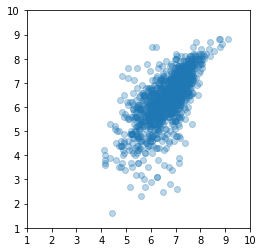

In [31]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Save the data for plot

In [32]:
# some random data
x1 = best_pred_lr.squeeze().numpy()
x2 = best_pred_relu.squeeze().numpy()
y = test_targets.squeeze().numpy()

np.save("../plt/data_fig1/pred_lr.npy", x1)
np.save("../plt/data_fig1/pred_relu.npy", x2)
np.save("../plt/data_fig1/true_ratings.npy", y)